In [35]:
import numpy as np                                            # matrix
import pandas as pd                                           # csv
from re import search

from tqdm  import tqdm

                                                              #cuda #scikitlearn
import os
import warnings
import tensorflow as tf                                       #neurolab #lasagne
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from PIL import Image
import PIL
import pathlib

# Confusion matrix
from sklearn.metrics import confusion_matrix

#from learntools.core import binder
#binder.bind(globals())
#from learntools.computer_vision.ex5 import *

# for the files and directories
import glob
import shutil
import natsort
from matplotlib import gridspec

#from tensorflow.keras.preprocessing import image_dataset_from_directory

import cv2
from random import shuffle
from os import listdir
#plt.style.use('fivethirtyeight')

print("Setup completed")

Setup completed


In [36]:
#pip install keras

In [37]:
#pip install tensorflow

In [38]:
#pip install opencv-python

In [39]:
DIR = r'/Users/vaishvaripatel/Desktop/PDD8/images/original dataset'

In [50]:
train=pd.read_csv(r"/Users/vaishvaripatel/Desktop/PDD8/labels/train.csv")
test=pd.read_csv(r"/Users/vaishvaripatel/Desktop/PDD8/labels/test.csv")

In [51]:
train.head()

,image_id,healthy,multiple_diseases,rust,fungus
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [52]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


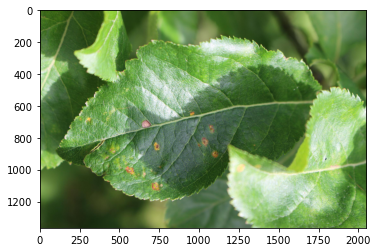

In [186]:
image1=Image.open(r'/Users/vaishvaripatel/Desktop/PDD8/images/original dataset/Test_1.jpg')
plt.imshow(image1)
plt.show()

# TRAINING DATA

In [54]:
class_names=train.loc[:,'healthy':].columns
print(class_names)

Index(['healthy', 'multiple_diseases', 'rust', 'fungus'], dtype='object')


In [55]:
#labelling

number=0
train['label']=0
for i in class_names:
    train['label']=train['label'] + train[i] * number
    number=number+1

In [56]:
train.head()

,image_id,healthy,multiple_diseases,rust,fungus,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [190]:
DIR

'/Users/vaishvaripatel/Desktop/PDD8/images/original dataset'

In [191]:
#pip install natsort

In [189]:
#natsorted(os.listdir(DIR))

In [59]:
def get_label_img(img):                         #EXTRACT
    if search("Train",img): 
        img=img.split('.')[0]                            
        label=train.loc[train['image_id']==img]['label']       # 0 = image id
        return label

In [61]:
from natsort import natsorted
def create_train_data():
    images=natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label=get_label_img(img)
        path=os.path.join(DIR,img) 
        
        if search("Train",img):
            if (img.split("_")[1].split(".")[0]) and label.item()==0:
                shutil.copy(path,r'/Users/vaishvaripatel/Desktop/PDD8/images/train/healthy')
            
            elif(img.split("_")[1].split(".")[0]) and label.item()==1:
                shutil.copy(path,r'/Users/vaishvaripatel/Desktop/PDD8/images/train/multiple_disease')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==2:
                shutil.copy(path,r'/Users/vaishvaripatel/Desktop/PDD8/images/train/rust')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==3:
                shutil.copy(path,r'/Users/vaishvaripatel/Desktop/PDD8/images/train/scab')
                
        elif search("Test",img):
            shutil.copy(path,r'/Users/vaishvaripatel/Desktop/PDD8/images/test')

In [63]:
shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/train')
shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/train/healthy')
shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/train/multiple_disease')
shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/train/rust')
shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/train/scab')

shutil.os.mkdir(r'/Users/vaishvaripatel/Desktop/PDD8/images/test')

In [64]:
train_dir=create_train_data()

100%|██████████| 3671/3671 [00:10<00:00, 359.23it/s]


# DATA PRE-PROCESSING 

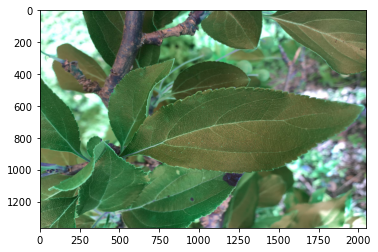

In [67]:
#DETECTION OF LEAF
Train_DIR=r'/Users/vaishvaripatel/Desktop/PDD8/images/train'
Categories=['healthy','multiple_disease','rust','fungus']

for j in Categories:
    path=os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

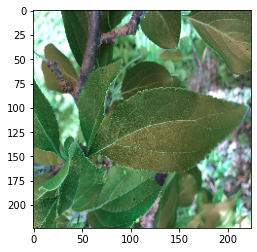

In [68]:
#RESIZE
IMG_SIZE=224 
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

# MODEL PREPARATION

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

In [70]:
datagen=ImageDataGenerator(rescale=1./255, # FIX PIXEL VALUE    # NORMALIZATION
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)  # HOW THE TRAINING IS GOING ON? #20%


train_datagen=datagen.flow_from_directory(r'/Users/vaishvaripatel/Desktop/PDD8/images/train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')

val_datagen=datagen.flow_from_directory(r'/Users/vaishvaripatel/Desktop/PDD8/images/train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')

Found 1470 images belonging to 4 classes.
Found 365 images belonging to 4 classes.


In [71]:
#cnn
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))      #filter
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))                                        #3 kernel
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))                                        #64 neuron
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))                                   #output #probability distribution

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()              #weights and biases

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

In [75]:
checkpoint=ModelCheckpoint(r'/Users/vaishvaripatel/Desktop/PDD8/models/leaf.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [76]:
model_history=model.fit_generator(train_datagen,validation_data=val_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=val_datagen.samples//16,
                                 callbacks=callbacks)

/Users/vaishvaripatel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
91/91 [==============================] - 192s 2s/step - loss: 1.3049 - accuracy: 0.3012 - val_loss: 1.2359 - val_accuracy: 0.3438

Epoch 00001: val_loss improved from inf to 1.23586, saving model to /Users/vaishvaripatel/Desktop/PDD8/models/leaf.h5
Epoch 2/30
91/91 [==============================] - 209s 2s/step - loss: 1.2023 - accuracy: 0.3787 - val_loss: 1.1486 - val_accuracy: 0.3892

Epoch 00002: val_loss improved from 1.23586 to 1.14858, saving model to /Users/vaishvaripatel/Desktop/PDD8/models/leaf.h5
Epoch 3/30
91/91 [==============================] - 203s 2s/step - loss: 1.0140 - accuracy: 0.5043 - val_loss: 0.8423 - val_accuracy: 0.6165

Epoch 00003: val_loss improved from 1.14858 to 0.84233, saving model to /Users/vaishvaripatel/Desktop/PDD8/models/leaf.h5
Epoch 4/30
91/91 [==============================] - 181s 2s/step - loss: 0.7486 - accuracy: 0.6434 - val_loss: 0.7526 - val_accuracy: 0.6705

Epoch 00004: val_loss improved from 0.84233 to 0.75265, saving model t

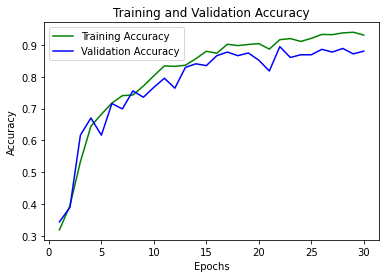

In [77]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,31)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

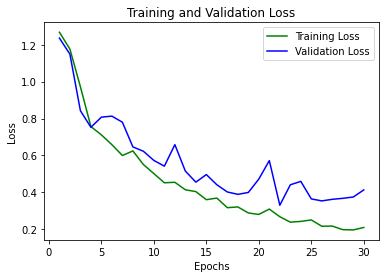

In [78]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# PREDICTION ON SINGLE IMAGE             # TESTING PART

3


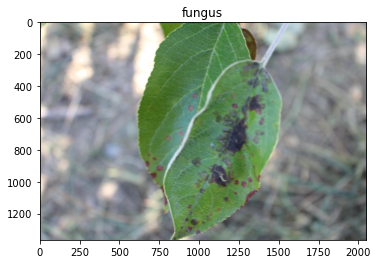

In [199]:
test_image=r'/Users/vaishvaripatel/Desktop/PDD8/images/test/Test_8.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255           #rescaling 
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)    #prediction
print(np.argmax(result))            #prints the maximum result
Categories=['healthy','multiple_disease','rust','fungus']
image_result=plt.imshow(image_result)  #PIL
plt.title(Categories[np.argmax(result)]) 
plt.show()


In [ ]:
if (result < 0.99).any:

    
    
else :
    
        print("Invalid Image")